# Graphs for paper for combinations

In [1]:
%reload_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True


In [3]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"


In [4]:
import sys
sys.path.append('../')


In [5]:
import neptune


In [6]:
## download from neptune
LOC_START_ID, LOC_END_ID = 1799, 1963
LOC_SKIP_IDS = []
LOC_RUN_IDS = [f"TSDRLOC-{i}" for i in range(LOC_START_ID, LOC_END_ID + 1) if i not in LOC_SKIP_IDS]
# LOC_RUN_IDS.extend([f"TSDRLOC-{i}" for i in range(2100, 2167 + 1)])  # bottomup tsdr
LOC_RUN_IDS.extend([f"TSDRLOC-{i}" for i in range(2181, 2191 + 1)])  # pelt kde_bandwidth 2.5 metricsifter


In [7]:
def convert_to_dataset_name(target_app: str, middleware: bool, manually_selected: bool) -> str:
    match target_app, middleware, manually_selected:
        case "sock-shop", _, True:
            return "SS-small"
        case "sock-shop", False, False:
            return "SS-medium"
        case "sock-shop", True, False:
            return "SS-large"
        case "train-ticket", _, True:
            return "TT-small"
        case "train-ticket", False, False:
            return "TT-medium"
        case "train-ticket", True, False:
            return "TT-large"
        case _:
            raise ValueError(f"Unknown combination: {target_app}, {middleware}, {manually_selected}")


In [8]:
def fetch_metadata(run_id: str, granularity: str = "cg") -> dict[str, str]:
    with neptune.init_run(
        project="yuuk1/tsdr-localization",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"].fetch() == True:
            return {}

        dataset = run["dataset"].fetch()
        target_app = dataset["target_app"]
        middleware = dataset["metric_types"]["middlewares"]
        manually_selected = dataset["use_manually_selected_metrics"]

        tsdr_params = run["parameters"]["tsdr"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        multi_dist_type = tsdr_params.get("step2_dbscan_dist_type", "")

        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (False, False, _, _, _):
                reduction = "None"
            case (True, True, "changepoint", "changepoint-kde", _):
                if tsdr_params.get("step2_changepoint_kde_bandwidth") != 2.5:
                    # only kde_bandwidth 2.5 in the paper
                    return {}
                reduction = "MetricSifter"
            case (True, False, "zscore_nsigma", _, _):
                reduction = "NSigma"
            case (True, False, "birch_model", _, _):
                reduction = "BIRCH"
            case (True, False, "two_samp_test", _, _):
                reduction = "K-S test"
            case (True, False, "fluxinfer", _, _):
                reduction = "FluxInfer-AD"
            case (False, True, _, "hdbscan", "sbd"):
                reduction = "HDBS-SBD"
            case (False, True, _, "hdbscan", "pearsonr"):
                reduction = "HDBS-R"
            case (_, _, _, _, _):
                assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        # 1. e-Diagnosis
        # 2. RCD
        # 3. CausalRCA+PageRank
        # 4. PC+RW-2
        # 5. GES+RW-2
        # 6. LiNGAM+RW-2
        # 7. PC+PageRank
        # 8. GES+PageRank
        # 9. LiNGAM+PageRank
        # 10. PC+HT
        # 11. GES+HT
        # 12. LiNGAM+HT
        localization: str
        loc_params = run["parameters"].fetch()
        pyrca_method = loc_params.get("method", "")
        walk_method = loc_params.get("walk_method", "")

        if pyrca_method == "epsilon_diagnosis":
            localization = "e-Diagnosis"
        elif loc_params.get("use_rcd", False):
            localization = "RCD"
        elif loc_params.get("use_causalrca", False):
            localization = "CausalRCA"
        elif pyrca_method == "pc" and walk_method == "rw-2":
            localization = "PC+RW-2"
        elif pyrca_method in ["ges", "fges"] and walk_method == "rw-2":
            localization = "GES+RW-2"
        elif pyrca_method == "lingam" and walk_method == "rw-2":
            localization = "LiNGAM+RW-2"
        elif pyrca_method == "call_graph" and walk_method == "rw-2":
            localization = "CG+RW-2"
        elif pyrca_method == "pc" and walk_method == "pagerank":
            localization = "PC+PageRank"
        elif pyrca_method in ["ges", "fges"] and walk_method == "pagerank":
            localization = "GES+PageRank"
        elif pyrca_method == "lingam" and walk_method == "pagerank":
            localization = "LiNGAM+PageRank"
        elif pyrca_method == "call_graph" and walk_method == "pagerank":
            localization = "CG+PageRank"
        elif pyrca_method == "pc" and walk_method == "ht":
            localization = "PC+HT"
        elif pyrca_method in ["ges", "fges"] and walk_method == "ht":
            localization = "GES+HT"
        elif pyrca_method == "lingam" and walk_method == "ht":
            localization = "LiNGAM+HT"
        elif pyrca_method == "call_graph" and walk_method == "ht":
            localization = "CG+HT"
        else:
            assert False, f"Unknown localization method: {loc_params}, RUN_ID: {run_id}"

        match granularity:
            case "cg":
                metric = run["scores"]["metric"].fetch()
                ac2 = metric["AC_2_mand"]
                ac5 = metric["AC_5_mand"]
                avg5 = metric["AVG_5_mand"]
                elapsed_time = run["elapsed_time"]["mean"]["elapsed_time"].fetch()
                return {"dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                            "reduction_method": reduction, "localization_method": localization,
                            "ac@2": ac2, "ac@5": ac5, "avg@5": avg5, "elapsed_time": elapsed_time}
            case "fg":
                path = f"/tmp/score-df-by-cause-comp-and-type-{run_id}.html"
                run["eval/score-df-by-cause-comp-and-type"].download(path)
                df = pd.concat(pd.read_html(path), axis=1)
                df.rename(
                    columns={
                        "Unnamed: 0": "dataset_id", "Unnamed: 1": "target_app", "Unnamed: 2": "chaos_comp", "Unnamed: 3": "chaos_type", "Unnamed: 4": "top_k"},
                    inplace=True,
                )

                path2 = f"/tmp/elapsed-time-df-by-cause-comp-and-type-{run_id}.html"
                run["elapsed_time/mean_by_chaos_type_and_chaos_comp"].download(path2)
                df2 = pd.concat(pd.read_html(path2), axis=1)
                df2.columns = df2.columns.set_levels(["chaos_type", "chaos_comp", "elapsed_time"], level=0)
                df2.columns = df2.columns.droplevel(1)
                elapsed_times = df2.set_index(["chaos_type", "chaos_comp"]).to_dict()["elapsed_time"]

                items = []
                for name, group in df.groupby(
                    ["dataset_id", "target_app", "chaos_comp", "chaos_type"], as_index=False,
                ):
                    ac_2 = group.loc[group["top_k"] == 2, "AC@K (metric) (mandatory)"].values[0]
                    ac_5 = group.loc[group["top_k"] == 5, "AC@K (metric) (mandatory)"].values[0]
                    avg_5 = group.loc[group["top_k"] == 5, "AVG@K (metric) (mandatory)"].values[0]
                    chaos_type = group["chaos_type"].iat[0]
                    chaos_comp = group["chaos_comp"].iat[0]
                    elapsed_time = elapsed_times[(chaos_type, chaos_comp)]
                    items.append({
                        "run_id": run_id,
                        "dataset": convert_to_dataset_name(group["target_app"].iat[0], middleware, manually_selected),
                        "reduction_method": reduction, "localization_method": localization,
                        "chaos_comp": chaos_comp, "chaos_type": chaos_type,
                        "ac@2": ac_2, "ac@5": ac_5, "avg@5": avg_5, "elapsed_time": elapsed_time,
                    })
                return items
            case _:
                assert False, f"Unknown granularity: {granularity}"


In [9]:
import joblib

items = joblib.Parallel(n_jobs=64)(joblib.delayed(fetch_metadata)(run, granularity="fg") for run in LOC_RUN_IDS)
assert items is not None
items = [item for item in items if item]
items = sum(items, [])
# assert len(items) <= len(LOC_RUN_IDS), f"{len(items)} > {len(LOC_RUN_IDS)}"


https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1816
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1808
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1823
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1814
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1835
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1817
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1828
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1831
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1804
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1827
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1818
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1820
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1807
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1803
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/t

In [10]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    loc_tsdr_df = pd.DataFrame(items)
    _loc_df = loc_tsdr_df.sort_values(["run_id", "dataset", "reduction_method", "localization_method", "chaos_comp", "chaos_type"], ascending=False).drop_duplicates(subset=["dataset", "reduction_method", "localization_method", "chaos_comp", "chaos_type"], keep="first")
    display(
        _loc_df.groupby(["dataset", "reduction_method", "localization_method"])[["ac@2", "ac@5", "avg@5", "elapsed_time"]].agg("mean")
    )


ac@2      ac@5     avg@5  \
dataset   reduction_method localization_method                                 
SS-large  BIRCH            RCD                  0.106250  0.130000  0.122875   
          FluxInfer-AD     RCD                  0.125000  0.130000  0.126833   
          HDBS-R           RCD                  0.118750  0.070833  0.093333   
          HDBS-SBD         RCD                  0.100000  0.075833  0.083500   
          K-S test         RCD                  0.131250  0.130833  0.126792   
          MetricSifter     RCD                  0.112500  0.138333  0.127875   
          NSigma           RCD                  0.106250  0.141667  0.119583   
          None             RCD                  0.087500  0.137500  0.113125   
SS-medium BIRCH            CG+PageRank          0.006250  0.012500  0.010417   
                           RCD                  0.331250  0.392500  0.343708   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          FluxInfer-AD     CG+PageRank          0.018750  0.016667  0.015417   
                           RCD                  0.312500  0.362500  0.328333   
                           e-Diagnosis          0.000000  0.002500  0.000500   
          HDBS-R           CG+PageRank          0.012500  0.024167  0.012958   
                           RCD                  0.212500  0.198333  0.220917   
                           e-Diagnosis          0.006250  0.022500  0.012625   
          HDBS-SBD         CG+PageRank          0.025000  0.037500  0.029375   
                           RCD                  0.312500  0.222500  0.258458   
                           e-Diagnosis          0.000000  0.022500  0.012208   
          K-S test         CG+PageRank          0.012500  0.012500  0.011042   
                           RCD                  0.331250  0.360000  0.338458   
                           e-Diagnosis          0.000000  0.002500  0.000500   
          MetricSifter     RCD                  0.381250  0.416667  0.392917   
          NSigma           CG+PageRank          0.025000  0.024167  0.021708   
                           RCD                  0.300000  0.396667  0.339958   
                           e-Diagnosis          0.000000  0.002500  0.000500   
          None             CG+PageRank          0.018750  0.029167  0.025208   
                           RCD                  0.300000  0.368333  0.325125   
                           e-Diagnosis          0.000000  0.000000  0.000000   
SS-small  BIRCH            CG+PageRank          0.050000  0.039167  0.040750   
                           LiNGAM+HT            0.162500  0.152500  0.163000   
                           LiNGAM+PageRank      0.137500  0.108333  0.131667   
                           PC+HT                0.231250  0.172500  0.204917   
                           PC+PageRank          0.081250  0.081667  0.086958   
                           RCD                  0.306250  0.226667  0.263250   
                           e-Diagnosis          0.031250  0.025000  0.030208   
          FluxInfer-AD     CG+PageRank          0.025000  0.028333  0.028375   
                           LiNGAM+HT            0.193750  0.169167  0.186333   
                           LiNGAM+PageRank      0.131250  0.112500  0.126250   
                           PC+HT                0.212500  0.174167  0.203375   
                           PC+PageRank          0.068750  0.070833  0.074375   
                           RCD                  0.300000  0.236667  0.279625   
                           e-Diagnosis          0.037500  0.031667  0.032792   
          HDBS-R           CG+PageRank          0.025000  0.033333  0.021667   
                           LiNGAM+HT            0.150000  0.101667  0.137000   
                           LiNGAM+PageRank      0.100000  0.085833  0.101333   
                           PC+HT                0.143750  0.105000  0.125792   
                           PC+PageRank          0.08

## Load tsdr

In [11]:
TSDR_START_ID, TSDR_END_ID = 1765, 1835
TSDR_RUN_IDS = [f"TSDR-{id}" for id in range(TSDR_START_ID, TSDR_END_ID + 1)]
# TSDR_RUN_IDS.extend([f"TSDR-{id}" for id in range(1903,1906+1)])
# TSDR_RUN_IDS.extend([f"TSDR-{id}" for id in range(1930,1932+1)])
TSDR_RUN_IDS.extend([f"TSDR-{id}" for id in range(1951,1956+1)])  # pelt c kde_bandwidth 2.5 metricsifter


In [12]:
def fetch_metadata_of_tsdr(run_id: str, granurality: str = "cg") -> dict[str, str|float]:
    with neptune.init_run(
        project="yuuk1/tsdr",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"] == True:
            return {}
        try:
            dataset = run["dataset"].fetch()
            target_app = dataset["target_app"]
            middleware = dataset["metric_types"]["middlewares"]
            manually_selected = dataset["use_manually_selected_metrics"]
        except neptune.exceptions.MissingFieldException:
            return {}

        tsdr_params = run["parameters"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
            multi_dist_type = multi_dist_type

        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (False, False, _, _, _):
                reduction = "None"
            case (True, True, "changepoint", "changepoint-kde", _):
                if tsdr_params.get("step1_changepoint_search_method") != "pelt" or tsdr_params.get("step2_changepoint_kde_bandwidth") != 2.5:
                    return {}
                reduction = "MetricSifter"
            case (True, False, "zscore_nsigma", _, _):
                reduction = "NSigma"
            case (True, False, "birch_model", _, _):
                reduction = "BIRCH"
            case (True, False, "two_samp_test", _, _):
                reduction = "K-S test"
            case (True, False, "fluxinfer", _, _):
                reduction = "FluxInfer-AD"
            case (False, True, _, "hdbscan", "sbd"):
                reduction = "HDBS-SBD"
            case (False, True, _, "hdbscan", "pearsonr"):
                reduction = "HDBS-R"
            case (_, _, _, _, _):
                assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        try:
            scores = run["scores"].fetch()
        except neptune.exceptions.MissingFieldException as e:
            print(f"Missing scores: RUN_ID {run_id}")
            return {}
        try:
            _ = run["scores/cause_metrics"].fetch()
        except neptune.exceptions.MissingFieldException as e:
            print(f"Missing scores: RUN_ID {run_id}")
            return {}

        match granurality:
            case "cg":
                tp = scores["cause_metrics"]["tp_mean"]
                tn = scores["cause_metrics"]["tn_mean"]
                fn = scores["cause_metrics"]["fn_mean"]
                fp = scores["cause_metrics"]["fp_mean"]
                recall = scores["cause_metrics"]["recall_mandatory_mean"]
                specificity = scores["cause_metrics"]["specificity_mean"]
                frr = scores["reduction_rate_mean"]
                proportion = scores["cause_metrics"]["proportion_mandatory_mean"]
                f1_score = scores["cause_metrics"]["f1_score_mean"]
                mcc = scores["cause_metrics"]["mcc_mean"]
                bacc = scores["cause_metrics"]["bacc_mean"]

                num_series = tuple([int (s) for s in scores["num_series"]["total"].split("/")])
                num_found_cause_metrics = scores["cause_metrics"]["num_mandatory_found_mean"]
                elapsed_time = scores["elapsed_time"]
                return {
                    "run_id": run_id,
                    "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                    "reduction_method": reduction,
                    "tp": tp, "tn": tn, "fn": fn, "fp": fp,
                    "specificity": specificity, "recall": recall, "proportion": proportion,
                    "f1_score": f1_score, "mcc": mcc, "bacc": bacc,
                    "reduction_rate": frr,
                    "elapsed_time": elapsed_time,
                    "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
                    "rs_ac@2": scores["RS_AC_2"], "rs_ac@5": scores["RS_AC_5"], "rs_avg@5": scores["RS_AVG_5"],
                }
            case "fg":
                csv_path = f"/tmp/summary_by_chaos_type_and_chaos_comp-{run_id}.csv"
                run["scores/summary_by_chaos_type_and_chaos_comp-csv"].download(csv_path)
                df = pd.read_csv(csv_path)
                last_phase = df["phase"].drop_duplicates().sort_values().iat[-1]
                df = df[df["phase"] == last_phase].set_index(["chaos_type", "chaos_comp", "phase"]).sort_index()
                items = []
                for index, row in df.iterrows():
                    tp = row["cause_metrics/tp_mean"]
                    tn = row["cause_metrics/tn_mean"]
                    fn = row["cause_metrics/fn_mean"]
                    fp = row["cause_metrics/fp_mean"]
                    recall = row["cause_metrics/recall_mandatory_mean"]
                    specificity = row["cause_metrics/specificity_mean"]
                    frr = row["reduction_rate_mean"]
                    proportion = row["cause_metrics/proportion_mandatory_mean"]
                    f1_score = row["cause_metrics/f1_score_mean"]
                    mcc = row["cause_metrics/mcc_mean"]
                    bacc = row["cause_metrics/bacc_mean"]

                    num_series = tuple([int (s) for s in row["num_series/total"].split("/")])
                    num_found_cause_metrics = row["cause_metrics/num_mandatory_found_mean"]
                    elapsed_time = row["elapsed_time"]
                    items.append({
                        "run_id": run_id,
                        "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                        "reduction_method": reduction,
                        "tp": tp, "tn": tn, "fn": fn, "fp": fp,
                        "specificity": specificity, "recall": recall, "proportion": proportion,
                        "f1_score": f1_score, "mcc": mcc, "bacc": bacc,
                        "reduction_rate": frr,
                        "elapsed_time": elapsed_time,
                        "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
                        "rs_ac@2": row["RS_AC_2"], "rs_ac@5": row["RS_AC_5"], "rs_avg@5": row["RS_AVG_5"],
                        "chaos_type": index[0], "chaos_comp": index[1],
                    })
                return items
            case _:
                assert False, f"Unknown granularity: {granurality}"


In [13]:
tsdr_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_metadata_of_tsdr)(run, granurality="cg") for run in TSDR_RUN_IDS)
assert tsdr_items is not None
tsdr_items = [item for item in tsdr_items if item]
assert len(tsdr_items) <= len(TSDR_RUN_IDS), f"{len(tsdr_items)} > {len(TSDR_RUN_IDS)}"


https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1767
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1774
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1772
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1768
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1769
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1773
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1766
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1770
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1765
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1771
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1786
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1777
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1779
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1775
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1778
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1776
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1783
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1780
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1784
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1785
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1787
https://app.neptune.ai/yuuk1/tsdr/

In [14]:
tsdr_fg_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_metadata_of_tsdr)(run, granurality="fg") for run in TSDR_RUN_IDS)
assert tsdr_fg_items is not None
tsdr_fg_items = [item for item in tsdr_fg_items if item]
tsdr_fg_items = sum(tsdr_fg_items, [])
# assert len(tsdr_items) <= len(TSDR_RUN_IDS), f"{len(tsdr_items)} > {len(TSDR_RUN_IDS)}"


https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1765
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1767
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1768
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1770
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1766
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1769
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1773
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1771
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1772
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1777
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1775
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1774
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1778
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1784
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1776
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1780
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1779
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1786
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1793
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1785
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1789
https://app.neptune.ai/yuuk1/tsdr/

In [15]:
def create_table_dataframe_multi_level(
    items: list[dict[str, str|float]],
    first_levels: list[str], second_levels: list[str], first_level_key: str, second_level_key: str, first_label: str, second_label: str,
    columns: list[str],
) -> pd.DataFrame:
    multi_level_indexes = pd.MultiIndex.from_product(
        [first_levels, second_levels], names=[first_label, second_label])
    multi_level_cols = pd.MultiIndex.from_product([first_levels, columns], names=['', ''])
    items_df = pd.DataFrame(items).drop_duplicates(subset=[first_level_key, second_level_key], keep="last")
    df = items_df.set_index([first_level_key, second_level_key]).reindex(index=multi_level_indexes)
    df = df.unstack(first_label)
    df = df.swaplevel(axis=1).sort_index(axis=1).reindex(
        index=second_levels, columns=multi_level_cols,
    )
    return df

from itertools import product

def to_latex_table(table_df: pd.DataFrame, first_levels: list[str], second_levels: list[str], columns: list[str], highlight_max_columns: list[str], highlight_min_columns: list[str]) -> str:
    styler = table_df[product(first_levels, columns)].style
    styler.highlight_max(subset=(second_levels, list(product(first_levels, highlight_max_columns))), props='textbf:--rwrap;')\
        .highlight_min(subset=(second_levels, list(product(first_levels, highlight_min_columns))), props='textbf:--rwrap;')
    # styler.format({k: '{:.4f}' for k in product(first_levels, ["bacc"])}, precision=3)
    styler.format(precision=3)
    return styler.to_latex(hrules=True)


In [16]:
reduction_methods = [
    "None", "NSigma", "BIRCH", "K-S test", "FluxInfer-AD", "HDBS-SBD", "HDBS-R", "MetricSifter"]
metrics = ["reduction_rate", "recall", "elapsed_time"]
ss_datasets = ["SS-small", "SS-medium", "SS-large"]
tt_datasets = ["TT-small", "TT-medium", "TT-large"]
datasets = ss_datasets + tt_datasets


In [17]:
tsdr_df = pd.DataFrame(tsdr_items)


In [18]:
ss_table_df = create_table_dataframe_multi_level(
    items=tsdr_items,
    first_levels=ss_datasets, second_levels=reduction_methods,
    first_level_key="dataset", second_level_key="reduction_method",
    first_label="Dataset", second_label="Reduction Method",
    columns=metrics,
)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(ss_table_df)

print(
    to_latex_table(ss_table_df, ss_datasets, reduction_methods, metrics, ["reduction_rate", "recall"], ["elapsed_time"])
)


SS-small                           SS-medium            \
                 reduction_rate  recall elapsed_time reduction_rate    recall   
Reduction Method                                                                
None                   0.000000  1.0000     0.308875       0.000000  1.000000   
NSigma                 0.129582  0.9875     0.572220       0.175686  0.987500   
BIRCH                  0.157009  1.0000     0.375484       0.182230  1.000000   
K-S test               0.129986  1.0000     0.588056       0.133909  1.000000   
FluxInfer-AD           0.129986  1.0000     0.596905       0.133909  1.000000   
HDBS-SBD               0.458447  0.4375     0.666308       0.689997  0.254375   
HDBS-R                 0.459056  0.4500     0.673615       0.694756  0.229375   
MetricSifter           0.314567  0.9750     0.827257       0.400597  0.987500   

                                    SS-large                         
                 elapsed_time reduction_rate    recall elapsed_time  
Reduction Method                                                     
None                 0.312021       0.000000  1.000000     0.450160  
NSigma               0.620755       0.317833  0.962538     1.139934  
BIRCH                0.419534       0.240866  0.976174     0.942817  
K-S test             0.640145       0.118753  0.996875     1.193169  
FluxInfer-AD         0.646770       0.118753  0.996875     1.197870  
HDBS-SBD             0.758412       0.843275  0.135164     6.486058  
HDBS-R               0.989142       0.836065  0.137156    81.353077  
MetricSifter         1.004561       0.424489  0.965511     2.682160

\begin{tabular}{lrrrrrrrrr}
\toprule
 & \multicolumn{3}{r}{SS-small} & \multicolumn{3}{r}{SS-medium} & \multicolumn{3}{r}{SS-large} \\
 & reduction_rate & recall & elapsed_time & reduction_rate & recall & elapsed_time & reduction_rate & recall & elapsed_time \\
Reduction Method &  &  &  &  &  &  &  &  &  \\
\midrule
None & 0.000 & \textbf{1.000} & \textbf{0.309} & 0.000 & \textbf{1.000} & \textbf{0.312} & 0.000 & \textbf{1.000} & \textbf{0.450} \\
NSigma & 0.130 & 0.988 & 0.572 & 0.176 & 0.988 & 0.621 & 0.318 & 0.963 & 1.140 \\
BIRCH & 0.157 & \textbf{1.000} & 0.375 & 0.182 & \textbf{1.000} & 0.420 & 0.241 & 0.976 & 0.943 \\
K-S test & 0.130 & \textbf{1.000} & 0.588 & 0.134 & \textbf{1.000} & 0.640 & 0.119 & 0.997 & 1.193 \\
FluxInfer-AD & 0.130 & \textbf{1.000} & 0.597 & 0.134 & \textbf{1.000} & 0.647 & 0.119 & 0.997 & 1.198 \\
HDBS-SBD & 0.458 & 0.438 & 0.666 & 0.690 & 0.254 & 0.758 & \textbf{0.843} & 0.135 & 6.486 \\
HDBS-R & \textbf{0.459} & 0.450 & 0.674 & \textbf{0.695} & 0.229 &

In [19]:
tt_table_df = create_table_dataframe_multi_level(
    items=tsdr_items,
    first_levels=tt_datasets, second_levels=reduction_methods,
    first_level_key="dataset", second_level_key="reduction_method",
    first_label="Dataset", second_label="Reduction Method",
    columns=metrics,
)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(tt_table_df)

print(
    to_latex_table(tt_table_df, tt_datasets, reduction_methods, metrics, ["reduction_rate", "recall"], ["elapsed_time"])
)


TT-small                             TT-medium  \
                 reduction_rate    recall elapsed_time reduction_rate   
Reduction Method                                                        
None                   0.000000  1.000000     0.487493       0.000000   
NSigma                 0.291384  1.000000     1.137826       0.328574   
BIRCH                  0.267389  0.976190     0.719648       0.271191   
K-S test               0.278187  1.000000     1.173876       0.264620   
FluxInfer-AD           0.278187  1.000000     1.177455       0.264620   
HDBS-SBD               0.524383  0.500000     1.416407       0.742996   
HDBS-R                 0.526682  0.619048     1.652402       0.742193   
MetricSifter           0.526641  0.928571     2.259414       0.600925   

                                              TT-large                         
                    recall elapsed_time reduction_rate    recall elapsed_time  
Reduction Method                                                               
None              1.000000     0.580712       0.000000  1.000000     1.604450  
NSigma            1.000000     1.492505       0.467887  0.989087     5.019302  
BIRCH             1.000000     1.097160       0.354351  0.992063     4.679712  
K-S test          1.000000     1.565933       0.243138  0.996032     5.337064  
FluxInfer-AD      1.000000     1.572307       0.243138  0.996032     5.358660  
HDBS-SBD          0.177778     2.223186       0.854109  0.131661    14.706824  
HDBS-R            0.185714     3.091267            NaN       NaN          NaN  
MetricSifter      0.952381     3.947160       0.572040  0.899802    23.039669

\begin{tabular}{lrrrrrrrrr}
\toprule
 & \multicolumn{3}{r}{TT-small} & \multicolumn{3}{r}{TT-medium} & \multicolumn{3}{r}{TT-large} \\
 & reduction_rate & recall & elapsed_time & reduction_rate & recall & elapsed_time & reduction_rate & recall & elapsed_time \\
Reduction Method &  &  &  &  &  &  &  &  &  \\
\midrule
None & 0.000 & \textbf{1.000} & \textbf{0.487} & 0.000 & \textbf{1.000} & \textbf{0.581} & 0.000 & \textbf{1.000} & \textbf{1.604} \\
NSigma & 0.291 & \textbf{1.000} & 1.138 & 0.329 & \textbf{1.000} & 1.493 & 0.468 & 0.989 & 5.019 \\
BIRCH & 0.267 & 0.976 & 0.720 & 0.271 & \textbf{1.000} & 1.097 & 0.354 & 0.992 & 4.680 \\
K-S test & 0.278 & \textbf{1.000} & 1.174 & 0.265 & \textbf{1.000} & 1.566 & 0.243 & 0.996 & 5.337 \\
FluxInfer-AD & 0.278 & \textbf{1.000} & 1.177 & 0.265 & \textbf{1.000} & 1.572 & 0.243 & 0.996 & 5.359 \\
HDBS-SBD & 0.524 & 0.500 & 1.416 & \textbf{0.743} & 0.178 & 2.223 & \textbf{0.854} & 0.132 & 14.707 \\
HDBS-R & \textbf{0.527} & 0.619 & 1.652 & 0.742

## Join tsdr and localization

In [20]:
import itertools

tsdr_fg_df = pd.DataFrame(tsdr_fg_items) # .set_index(["dataset", "reduction_method", "chaos_type", "chaos_comp"])
loc_rs_df = pd.DataFrame(
    {
        "dataset": row["dataset"], "localization_method": "RS", "reduction_method": row["reduction_method"],
        "ac@2": row["rs_ac@2"], "ac@5": row["rs_ac@5"], "avg@5": row["rs_avg@5"], "chaos_type": row["chaos_type"], "chaos_comp": row["chaos_comp"],
    } for _, row in tsdr_fg_df.iterrows()
)
loc_rs_df


,dataset,localization_method,reduction_method,ac@2,ac@5,avg@5,chaos_type,chaos_comp
0,SS-small,RS,NSigma,0.037072,0.090112,0.054750,pod-cpu-hog,carts
1,SS-small,RS,NSigma,0.035944,0.087448,0.053110,pod-cpu-hog,carts-db
2,SS-small,RS,NSigma,0.037469,0.091051,0.055327,pod-cpu-hog,catalogue
3,SS-small,RS,NSigma,0.039169,0.095063,0.057798,pod-cpu-hog,catalogue-db
4,SS-small,RS,NSigma,0.034951,0.085098,0.051665,pod-cpu-hog,orders
...,...,...,...,...,...,...,...,...
989,TT-large,RS,MetricSifter,0.003426,0.008542,0.005131,pod-memory-hog,ts-order-service
990,TT-large,RS,MetricSifter,0.003174,0.007917,0.004755,pod-memory-hog,ts-station-service
991,TT-large,RS,MetricSifter,0.003340,0.008327,0.005002,pod-memory-hog,ts-train-service
992,TT-large,RS,MetricSifter,0.003804,0.009482,0.005697,pod-memory-hog,ts-travel-service


In [21]:
combined_loc_tsdr_df = pd.concat([loc_tsdr_df, loc_rs_df], axis=0)

joined_df = combined_loc_tsdr_df.set_index(["dataset", "localization_method"]).join(
    tsdr_fg_df.set_index(["dataset", "reduction_method", "chaos_type", "chaos_comp"]), how="outer", on=['dataset', 'reduction_method', 'chaos_type', 'chaos_comp'],
    lsuffix='_loc', rsuffix='_tsdr',
)
joined_df["elapsed_time_sum"] = joined_df["elapsed_time_loc"] + joined_df["elapsed_time_tsdr"]
aggregated_joined_df = joined_df.loc[:, ~joined_df.columns.isin(['run_id', 'run_id_tsdr', 'run_id_loc', 'chaos_comp', 'chaos_type'])].reset_index().groupby(['dataset', 'localization_method', 'reduction_method'], as_index=True).agg("mean").sort_index().loc[:, ["ac@2", "ac@5", "avg@5", "elapsed_time_sum", "elapsed_time_tsdr", "elapsed_time_loc", "bacc", "recall", "mcc", "specificity", "f1_score"]]
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.float_format", lambda x: f"{x:.4f}"):
    display(
        # joined_df.reset_index().set_index(["dataset", "localization_method", "reduction_method"])
        aggregated_joined_df
    )


ac@2   ac@5  avg@5  \
dataset   localization_method reduction_method                        
SS-large  RCD                 BIRCH            0.1062 0.1300 0.1229   
                              FluxInfer-AD     0.1250 0.1300 0.1268   
                              HDBS-R           0.1188 0.0708 0.0933   
                              HDBS-SBD         0.1000 0.0758 0.0835   
                              K-S test         0.1313 0.1308 0.1268   
                              MetricSifter     0.1125 0.1383 0.1279   
                              NSigma           0.1062 0.1417 0.1196   
                              None             0.0875 0.1375 0.1131   
          RS                  BIRCH            0.0127 0.0314 0.0190   
                              FluxInfer-AD     0.0113 0.0280 0.0168   
                              HDBS-R           0.0075 0.0186 0.0112   
                              HDBS-SBD         0.0079 0.0196 0.0118   
                              K-S test         0.0113 0.0280 0.0168   
                              MetricSifter     0.0166 0.0410 0.0248   
                              NSigma           0.0139 0.0343 0.0207   
                              None             0.0100 0.0248 0.0150   
SS-medium CG+PageRank         BIRCH            0.0063 0.0125 0.0104   
                              FluxInfer-AD     0.0188 0.0167 0.0154   
                              HDBS-R           0.0125 0.0242 0.0130   
                              HDBS-SBD         0.0250 0.0375 0.0294   
                              K-S test         0.0125 0.0125 0.0110   
                              NSigma           0.0250 0.0242 0.0217   
                              None             0.0188 0.0292 0.0252   
          RCD                 BIRCH            0.3312 0.3925 0.3437   
                              FluxInfer-AD     0.3125 0.3625 0.3283   
                              HDBS-R           0.2125 0.1983 0.2209   
                              HDBS-SBD         0.3125 0.2225 0.2585   
                              K-S test         0.3312 0.3600 0.3385   
                              MetricSifter     0.3812 0.4167 0.3929   
                              NSigma           0.3000 0.3967 0.3400   
                              None             0.3000 0.3683 0.3251   
          RS                  BIRCH            0.0575 0.1369 0.0839   
                              FluxInfer-AD     0.0543 0.1298 0.0795   
                              HDBS-R           0.0356 0.0860 0.0524   
                              HDBS-SBD         0.0375 0.0902 0.0550   
                              K-S test         0.0543 0.1298 0.0795   
                              MetricSifter     0.0808 0.1880 0.1165   
                              NSigma           0.0559 0.1335 0.0818   
                              None             0.0472 0.1133 0.0692   
          e-Diagnosis         BIRCH            0.0000 0.0000 0.0000   
                              FluxInfer-AD     0.0000 0.0025 0.0005   
                              HDBS-R           0.0063 0.0225 0.0126   
                              HDBS-SBD         0.0000 0.0225 0.0122   
                              K-S test         0.0000 0.0025 0.0005   
                              NSigma           0.0000 0.0025 0.0005   
                              None             0.0000 0.0000 0.0000   
SS-small  CG+PageRank         BIRCH            0.0500 0.0392 0.0408   
                              FluxInfer-AD     0.0250 0.0283 0.0284   
                              HDBS-R           0.0250 0.0333 0.0217   
                              HDBS-SBD         0.0312 0.0408 0.0296   
                              K-S test         0.0250 0.0292 0.0267   
                              MetricSifter     0.0781 0.0660 0.0803   
                              NSigma           0.0375 0.0392 0.0405   
                              None             0.0375 0.0217 0.0264   
          LiNGAM+HT           BIRCH            0.1625 0.1525 0.1630   
  

In [22]:
joined_df.to_csv("materials/joined_df.csv")
aggregated_joined_df.to_csv("materials/aggregated_joined_df.csv")


In [23]:
aggregated_joined_df = pd.read_csv("materials/aggregated_joined_df.csv")
aggregated_joined_df.replace({"reduction_method": np.NAN}, "None", inplace=True)
aggregated_joined_df = aggregated_joined_df.reset_index().drop(index=aggregated_joined_df.reset_index().query("dataset != 'SS-small' & localization_method in ['CG+PageRank', 'e-Diagnosis']").index).drop(columns=["index"])


In [24]:
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.float_format", lambda x: f"{x:.4f}"):
    display(
        aggregated_joined_df.set_index(["dataset", "localization_method", "reduction_method"]).sort_index()
    )


ac@2   ac@5  avg@5  \
dataset   localization_method reduction_method                        
SS-large  RCD                 BIRCH            0.1062 0.1300 0.1229   
                              FluxInfer-AD     0.1250 0.1300 0.1268   
                              HDBS-R           0.1187 0.0708 0.0933   
                              HDBS-SBD         0.1000 0.0758 0.0835   
                              K-S test         0.1313 0.1308 0.1268   
                              MetricSifter     0.1125 0.1383 0.1279   
                              NSigma           0.1062 0.1417 0.1196   
                              None             0.0875 0.1375 0.1131   
          RS                  BIRCH            0.0127 0.0314 0.0190   
                              FluxInfer-AD     0.0113 0.0280 0.0168   
                              HDBS-R           0.0075 0.0186 0.0112   
                              HDBS-SBD         0.0079 0.0196 0.0118   
                              K-S test         0.0113 0.0280 0.0168   
                              MetricSifter     0.0166 0.0410 0.0248   
                              NSigma           0.0139 0.0343 0.0207   
                              None             0.0100 0.0248 0.0150   
SS-medium RCD                 BIRCH            0.3312 0.3925 0.3437   
                              FluxInfer-AD     0.3125 0.3625 0.3283   
                              HDBS-R           0.2125 0.1983 0.2209   
                              HDBS-SBD         0.3125 0.2225 0.2585   
                              K-S test         0.3312 0.3600 0.3385   
                              MetricSifter     0.3812 0.4167 0.3929   
                              NSigma           0.3000 0.3967 0.3400   
                              None             0.3000 0.3683 0.3251   
          RS                  BIRCH            0.0575 0.1369 0.0839   
                              FluxInfer-AD     0.0543 0.1298 0.0795   
                              HDBS-R           0.0356 0.0860 0.0524   
                              HDBS-SBD         0.0375 0.0902 0.0550   
                              K-S test         0.0543 0.1298 0.0795   
                              MetricSifter     0.0808 0.1880 0.1165   
                              NSigma           0.0559 0.1335 0.0818   
                              None             0.0472 0.1133 0.0692   
SS-small  CG+PageRank         BIRCH            0.0500 0.0392 0.0408   
                              FluxInfer-AD     0.0250 0.0283 0.0284   
                              HDBS-R           0.0250 0.0333 0.0217   
                              HDBS-SBD         0.0312 0.0408 0.0296   
                              K-S test         0.0250 0.0292 0.0267   
                              MetricSifter     0.0781 0.0660 0.0803   
                              NSigma           0.0375 0.0392 0.0405   
                              None             0.0375 0.0217 0.0264   
          LiNGAM+HT           BIRCH            0.1625 0.1525 0.1630   
                              FluxInfer-AD     0.1938 0.1692 0.1863   
                              HDBS-R           0.1500 0.1017 0.1370   
                              HDBS-SBD         0.1250 0.0925 0.1237   
                              K-S test         0.2000 0.1742 0.1927   
                              MetricSifter     0.2016 0.1712 0.1970   
                              NSigma           0.1688 0.1550 0.1718   
                              None             0.1625 0.1650 0.1751   
          LiNGAM+PageRank     BIRCH            0.1375 0.1083 0.1317   
                              FluxInfer-AD     0.1313 0.1125 0.1263   
                              HDBS-R           0.1000 0.0858 0.1013   
                              HDBS-SBD         0.1187 0.0775 0.1157   
                              K-S test         0.1313 0.1125 0.1263   
                              MetricSifter     0.1437 0.1167 0.1363   
                              NSigma           0.1313 0.1042 0.1196   
  

In [25]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: -(x[x["reduction_method"] != "MetricSifter"]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"].iloc[0])) * 100
).groupby(["dataset", "localization_method"]).agg(["mean", "max", "min"])


mean        max       min
dataset   localization_method                               
SS-large  RCD                  1.558332   4.437500  0.104169
          RS                   0.887481   1.359392  0.406491
SS-medium RCD                  8.506541  17.199988  4.920825
          RS                   4.486880   6.405989  3.254175
SS-small  CG+PageRank          4.976636   5.867706  3.959375
          LiNGAM+HT            3.271430   7.325000  0.420844
          LiNGAM+PageRank      1.387498   3.491663  0.041663
          PC+HT                4.739286   9.841662  1.929175
          PC+PageRank          4.372613   5.237494  3.537494
          RCD                  5.949866  14.567731  1.659387
          RS                   2.331953   3.515012  1.555883
          e-Diagnosis          0.904168   2.354169  0.187500
TT-large  RS                   0.169288   0.259301  0.051460
TT-medium RCD                 -0.424662   2.157934 -3.994450
          RS                   1.247167   1.679841  0.905515
TT-small  RCD                  8.918879  12.723814  4.183330
          RS                   0.641942   0.890924  0.501331

In [26]:
# 平均増加精度
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: -(x[x["reduction_method"] != "MetricSifter"]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"].iloc[0])) * 100
).agg(["mean", "max", "min"])


mean     3.197524
max     17.199988
min     -3.994450
Name: avg@5, dtype: float64

In [27]:
aggregated_joined_df.reset_index().query("localization_method == 'RS'").groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: -(x[x["reduction_method"] != "MetricSifter"]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"].iloc[0])) * 100
).mean()


1.6630167148825363

In [28]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: (x[x["reduction_method"] == "MetricSifter"]["avg@5"] - x[x["reduction_method"] != "MetricSifter"]["avg@5"].max()) * 100
).agg(["mean", "max", "min"])


mean    1.389657
max     4.920825
min    -3.994450
Name: avg@5, dtype: float64

In [29]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: (x[x["reduction_method"] == "MetricSifter"]["avg@5"] - x[x["reduction_method"] != "MetricSifter"]["avg@5"].max()) * 100
).to_frame()


avg@5
dataset   localization_method              
SS-large  RCD                 5    0.104169
          RS                  13   0.406491
SS-medium RCD                 21   4.920825
          RS                  29   3.254175
SS-small  CG+PageRank         37   3.959375
          LiNGAM+HT           45   0.420844
          LiNGAM+PageRank     53   0.041663
          PC+HT               61   1.929175
          PC+PageRank         69   3.537494
          RCD                 77   1.659387
          RS                  85   1.555883
          e-Diagnosis         93   0.187500
TT-large  RS                  100  0.051460
TT-medium RCD                 108 -3.994450
          RS                  116  0.905515
TT-small  RCD                 124  4.183330
          RS                  132  0.501331

In [30]:
# T(s) 平均改善率
aggregated_joined_df.groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: x[x["reduction_method"] != "MetricSifter"]["elapsed_time_sum"] / float(x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"])
).dropna().agg(["mean", "max", "min"])


/tmp/ipykernel_1731813/1813844730.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lambda x: x[x["reduction_method"] != "MetricSifter"]["elapsed_time_sum"] / float(x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"])


mean    1.354293
max     3.159701
min     0.221026
Name: elapsed_time_sum, dtype: float64

In [31]:
aggregated_joined_df.groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: x.iloc[x[x["reduction_method"] != "MetricSifter"]["avg@5"].argmax(), :]["elapsed_time_sum"] / x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"]
).agg(["mean", "max", "min"])


mean    1.334174
max     1.747044
min     0.221026
Name: elapsed_time_sum, dtype: float64

In [32]:
aggregated_joined_df.groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: x.iloc[x[x["reduction_method"] != "MetricSifter"]["avg@5"].argmax(), :]["elapsed_time_sum"] / x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"]
)


dataset    localization_method     
SS-large   RCD                  5      1.619395
           RS                   13          NaN
SS-medium  RCD                  28     1.747044
           RS                   36          NaN
SS-small   CG+PageRank          51     0.231739
           LiNGAM+HT            59     1.734567
           LiNGAM+PageRank      67     1.695089
           PC+HT                75     1.681808
           PC+PageRank          83     0.221026
           RCD                  91     1.388668
           RS                   99          NaN
           e-Diagnosis          107    1.269880
TT-large   RS                   114         NaN
TT-medium  RCD                  129    1.710788
           RS                   137         NaN
TT-small   RCD                  159    1.375909
           RS                   167         NaN
Name: elapsed_time_sum, dtype: float64

In [33]:
aggregated_joined_df.groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: (x[x["reduction_method"] != "None"]["avg@5"] - x[x["reduction_method"] == "None"]["avg@5"].iat[0]) * 100
).agg(["mean", "max", "min"])


mean    -0.253561
max      6.779156
min    -10.862512
Name: avg@5, dtype: float64

In [34]:
# None 悪化率が悪いケースを抽出

none_dec_ranks = aggregated_joined_df.groupby(["dataset", "localization_method", "reduction_method"], as_index=True).apply(
    lambda x: (x["avg@5"] - float(aggregated_joined_df.query("dataset == @x.name[0] & localization_method == @x.name[1] & reduction_method == 'None'")["avg@5"].iat[0])) * 100
).sort_values(ascending=True).where(lambda x: x < 0).dropna()


In [35]:
none_dec_ranks


dataset    localization_method  reduction_method     
SS-small   RCD                  HDBS-SBD          89    -10.862512
SS-medium  RCD                  HDBS-R            25    -10.420831
SS-small   RCD                  HDBS-R            88    -10.404169
TT-small   RCD                  HDBS-R            156    -8.540484
                                HDBS-SBD          157    -7.475020
                                NSigma            160    -6.800000
SS-medium  RCD                  HDBS-SBD          26     -6.666675
SS-small   PC+HT                HDBS-R            72     -6.312500
           LiNGAM+HT            HDBS-SBD          57     -5.137494
           PC+HT                HDBS-SBD          73     -4.562506
           LiNGAM+HT            HDBS-R            56     -3.808319
TT-small   RCD                  BIRCH             154    -3.666670
                                FluxInfer-AD      155    -3.666670
SS-small   LiNGAM+PageRank      HDBS-R            64     -3.450000
TT-small

In [36]:
print(none_dec_ranks.xs("HDBS-SBD", level=2).size + none_dec_ranks.xs("HDBS-R", level=2).size / none_dec_ranks.size)
none_dec_ranks.xs("HDBS-SBD", level=2).size + none_dec_ranks.xs("HDBS-R", level=2).size, none_dec_ranks.size


13.341463414634147


(27, 41)

In [37]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: x[x["reduction_method"] != "None"]["elapsed_time_sum"].min() / x[x["reduction_method"] == "None"]["elapsed_time_sum"]
)


dataset    localization_method     
SS-large   RCD                  7      0.152306
           RS                   15          NaN
SS-medium  RCD                  23     0.301362
           RS                   31          NaN
SS-small   CG+PageRank          39     0.198720
           LiNGAM+HT            47     0.168061
           LiNGAM+PageRank      55     0.167703
           PC+HT                63     0.076822
           PC+PageRank          71     0.069952
           RCD                  79     0.543875
           RS                   87          NaN
           e-Diagnosis          95     0.597968
TT-large   RS                   102         NaN
TT-medium  RCD                  110    0.224458
           RS                   118         NaN
TT-small   RCD                  126    0.431603
           RS                   134         NaN
Name: elapsed_time_sum, dtype: float64

In [38]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"] / x[x["reduction_method"].isin(["HDBS-R", "HDBS-SBD"])]["elapsed_time_sum"].min()
)


dataset    localization_method     
SS-large   RCD                  5      3.707708
           RS                   13          NaN
SS-medium  RCD                  21     1.633757
           RS                   29          NaN
SS-small   CG+PageRank          37     0.948773
           LiNGAM+HT            45     2.365290
           LiNGAM+PageRank      53     2.372438
           PC+HT                61     4.119716
           PC+PageRank          69     4.524353
           RCD                  77     1.132842
           RS                   85          NaN
           e-Diagnosis          93     1.162303
TT-large   RS                   100         NaN
TT-medium  RCD                  108    2.059513
           RS                   116         NaN
TT-small   RCD                  124    1.161657
           RS                   132         NaN
Name: elapsed_time_sum, dtype: float64

In [39]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: (1 - x[x["reduction_method"].isin(["HDBS-R", "HDBS-SBD"])]["elapsed_time_sum"] / float(x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"]))
).mean()


/tmp/ipykernel_1731813/4271325615.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lambda x: (1 - x[x["reduction_method"].isin(["HDBS-R", "HDBS-SBD"])]["elapsed_time_sum"] / float(x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"]))


0.40746542311731254

In [40]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: -(x[x["reduction_method"].isin(["HDBS-R", "HDBS-SBD"])]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"])) * 100
).mean()


/tmp/ipykernel_1731813/3512586481.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lambda x: -(x[x["reduction_method"].isin(["HDBS-R", "HDBS-SBD"])]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"])) * 100


5.452180439004561

In [41]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: (x[x["reduction_method"] == "MetricSifter"]["avg@5"] - x[x["reduction_method"].isin(["NSigma", "K-S test", "FluxInfer-AD", "BIRCH"])]["avg@5"].max()) * 100
)


dataset    localization_method     
SS-large   RCD                  5      0.104169
           RS                   13     0.406491
SS-medium  RCD                  21     4.920825
           RS                   29     3.254175
SS-small   CG+PageRank          37     3.959375
           LiNGAM+HT            45     0.420844
           LiNGAM+PageRank      53     0.458338
           PC+HT                61     1.929175
           PC+PageRank          69     3.979156
           RCD                  77     1.659387
           RS                   85     1.555883
           e-Diagnosis          93     0.187500
TT-large   RS                   100    0.051460
TT-medium  RCD                  108   -3.994450
           RS                   116    0.905515
TT-small   RCD                  124    7.183330
           RS                   132    0.501331
Name: avg@5, dtype: float64

In [42]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: (x[x["reduction_method"] == "MetricSifter"]["avg@5"] - x[x["reduction_method"].isin(["NSigma", "K-S test", "FluxInfer-AD", "BIRCH"])]["avg@5"].max()) * 100
).agg(["mean", "max", "min"])


mean    1.616618
max     7.183330
min    -3.994450
Name: avg@5, dtype: float64

In [43]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: -(x[x["reduction_method"].isin(["NSigma", "K-S test", "FluxInfer-AD", "BIRCH"])]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"])) * 100
).mean()


/tmp/ipykernel_1731813/2445769460.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lambda x: -(x[x["reduction_method"].isin(["NSigma", "K-S test", "FluxInfer-AD", "BIRCH"])]["avg@5"] - float(x[x["reduction_method"] == "MetricSifter"]["avg@5"])) * 100


2.263711116349953

In [44]:
aggregated_joined_df.reset_index().groupby(["dataset", "localization_method"], as_index=True).apply(
    lambda x: x[x["reduction_method"].isin(["NSigma", "K-S test", "FluxInfer-AD", "BIRCH"])]["elapsed_time_sum"] / float(x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"])
).mean()


/tmp/ipykernel_1731813/1273374928.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lambda x: x[x["reduction_method"].isin(["NSigma", "K-S test", "FluxInfer-AD", "BIRCH"])]["elapsed_time_sum"] / float(x[x["reduction_method"] == "MetricSifter"]["elapsed_time_sum"])


1.538833593365088

In [45]:
# calculate correlation with (ac@2, ac@5, avg@5), and (bacc, recall, mcc)
loc_scores = ["ac@2", "ac@5", "avg@5"]
tsdr_all_scores = ["bacc", "recall", "mcc", "specificity", "f1_score"]

def correlation_fn(group: pd.Series, tsdr_scores: list[str] = ["bacc"], loc_score: str = "avg@5", method="pearson"):
    # display(group[loc_scores], group[tsdr_scores])
    # print("print", group[tsdr_scores], group[loc_scores[-1]])
    z = group[tsdr_scores].corrwith(group[loc_score], method=method, axis=0)
    return z

def correlation_pval_fn(group: pd.Series, tsdr_scores: list[str] = ["bacc"], loc_score: str = "avg@5"):
    res = {}
    for tsdr_score, loc_score in product(tsdr_scores, loc_scores):
        r = scipy.stats.pearsonr(group[tsdr_score], group[loc_score], alternative="greater")
        res[tsdr_score] = r.pvalue
    return pd.Series(res)

for loc_score in loc_scores:
    for method in ["pearson", "spearman", "kendall"]:
        display(
            (loc_score, method),
            aggregated_joined_df.groupby(['dataset', 'localization_method'], as_index=True).apply(
                correlation_fn, tsdr_scores=tsdr_all_scores, loc_score=loc_score, method=method,
            ).dropna()
        )


('ac@2', 'pearson')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.150809  0.073218  0.672900    -0.017458   
          RS                   0.979338  0.728354  0.190826    -0.421889   
SS-medium RCD                  0.795623  0.626375  0.097565    -0.361447   
          RS                   0.987798  0.710650  0.178081    -0.360056   
SS-small  CG+PageRank          0.667667  0.333544  0.052562     0.046572   
          LiNGAM+HT            0.836190  0.755126  0.106584    -0.470938   
          LiNGAM+PageRank      0.663889  0.838485 -0.507463    -0.748748   
          PC+HT                0.925659  0.877753 -0.055724    -0.586948   
          PC+PageRank          0.287356 -0.172448  0.153112     0.515754   
          RCD                  0.916244  0.974428 -0.090217    -0.746637   
          RS                   0.986032  0.765057  0.163305    -0.358638   
          e-Diagnosis          0.924011  0.908347  0.107813    -0.636346   
TT-large  RS                   0.965288  0.456867  0.445468     0.158761   
TT-medium RCD                  0.349540  0.486655  0.026162    -0.388757   
          RS                   0.961027  0.625904  0.240958    -0.077513   
TT-small  RCD                  0.308737  0.431862 -0.444884    -0.193405   
          RS                   0.952755  0.342302  0.486658     0.413268   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.088934  
          RS                   0.999774  
SS-medium RCD                  0.815887  
          RS                   0.998614  
SS-small  CG+PageRank          0.750177  
          LiNGAM+HT            0.824594  
          LiNGAM+PageRank      0.682116  
          PC+HT                0.915586  
          PC+PageRank          0.416141  
          RCD                  0.883924  
          RS                   0.999938  
          e-Diagnosis          0.879286  
TT-large  RS                   0.999995  
TT-medium RCD                  0.294060  
          RS                   0.999975  
TT-small  RCD                  0.450152  
          RS                   0.999996

('ac@2', 'spearman')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.096386  0.132530  0.240964    -0.096386   
          RS                   1.000000  0.180723  0.927711    -0.156627   
SS-medium RCD                  0.719566  0.383635  0.731762    -0.048784   
          RS                   1.000000  0.398255  0.927711    -0.180723   
SS-small  CG+PageRank          0.481628  0.006584  0.629822    -0.111145   
          LiNGAM+HT            0.807229  0.423949  0.156627    -0.349398   
          LiNGAM+PageRank      0.589057  0.588852  0.024544    -0.589057   
          PC+HT                0.890925  0.523464  0.345461    -0.272732   
          PC+PageRank         -0.115154 -0.704414  0.478797     0.660618   
          RCD                  0.813253  0.327597  0.439759    -0.343373   
          RS                   1.000000  0.488184  0.469880    -0.156627   
          e-Diagnosis          0.845128  0.563223  0.099427    -0.347994   
TT-large  RS                   1.000000 -0.236364  0.963636     0.236364   
TT-medium RCD                  0.082323  0.250000  0.082323    -0.137205   
          RS                   1.000000  0.466498  0.927711    -0.180723   
TT-small  RCD                  0.220896  0.750680  0.368161    -0.515425   
          RS                   1.000000  0.242437  1.000000     0.421687   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.096386  
          RS                   1.000000  
SS-medium RCD                  0.719566  
          RS                   1.000000  
SS-small  CG+PageRank          0.481628  
          LiNGAM+HT            0.807229  
          LiNGAM+PageRank      0.589057  
          PC+HT                0.890925  
          PC+PageRank         -0.115154  
          RCD                  0.813253  
          RS                   1.000000  
          e-Diagnosis          0.845128  
TT-large  RS                   1.000000  
TT-medium RCD                  0.082323  
          RS                   1.000000  
TT-small  RCD                  0.147264  
          RS                   1.000000

('ac@2', 'kendall')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.074074  0.148148  0.222222    -0.074074   
          RS                   1.000000 -0.037037  0.851852     0.111111   
SS-medium RCD                  0.615840  0.305505  0.615840     0.000000   
          RS                   1.000000  0.293972  0.851852     0.037037   
SS-small  CG+PageRank          0.392837  0.000000  0.549972    -0.078567   
          LiNGAM+HT            0.740741  0.293972  0.148148    -0.148148   
          LiNGAM+PageRank      0.500370  0.480079  0.038490    -0.423390   
          PC+HT                0.792594  0.427960  0.264198    -0.113228   
          PC+PageRank         -0.188713 -0.513553  0.339683     0.415168   
          RCD                  0.666667  0.167984  0.296296    -0.222222   
          RS                   1.000000  0.377964  0.407407     0.111111   
          e-Diagnosis          0.762444  0.455016  0.120386    -0.200643   
TT-large  RS                   1.000000 -0.400000  0.900000     0.400000   
TT-medium RCD                  0.045361  0.196116  0.045361    -0.136083   
          RS                   1.000000  0.362887  0.851852     0.037037   
TT-small  RCD                  0.153960  0.610170  0.307920    -0.384900   
          RS                   1.000000  0.246183  1.000000     0.407407   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.074074  
          RS                   1.000000  
SS-medium RCD                  0.615840  
          RS                   1.000000  
SS-small  CG+PageRank          0.392837  
          LiNGAM+HT            0.740741  
          LiNGAM+PageRank      0.500370  
          PC+HT                0.792594  
          PC+PageRank         -0.188713  
          RCD                  0.666667  
          RS                   1.000000  
          e-Diagnosis          0.762444  
TT-large  RS                   1.000000  
TT-medium RCD                  0.045361  
          RS                   1.000000  
TT-small  RCD                  0.076980  
          RS                   1.000000

('ac@5', 'pearson')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.677645  0.983962 -0.249221    -0.877500   
          RS                   0.978784  0.731915  0.188770    -0.426497   
SS-medium RCD                  0.823231  0.967301 -0.127627    -0.796415   
          RS                   0.988892  0.727189  0.173406    -0.381301   
SS-small  CG+PageRank          0.508075 -0.024140  0.493646     0.471470   
          LiNGAM+HT            0.831848  0.968026 -0.228902    -0.808619   
          LiNGAM+PageRank      0.798945  0.946575 -0.347594    -0.803049   
          PC+HT                0.914383  0.967728 -0.149684    -0.737714   
          PC+PageRank          0.309432 -0.167018  0.335294     0.526076   
          RCD                  0.834331  0.996797 -0.224763    -0.851633   
          RS                   0.989611  0.787100  0.148171    -0.390163   
          e-Diagnosis          0.827812  0.957002 -0.192224    -0.794771   
TT-large  RS                   0.965435  0.457488  0.445377     0.158137   
TT-medium RCD                  0.449779  0.425063  0.027099    -0.212256   
          RS                   0.962075  0.629242  0.240401    -0.081355   
TT-small  RCD                  0.535311  0.823582 -0.180286    -0.422065   
          RS                   0.954635  0.349658  0.484932     0.406767   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.799733  
          RS                   0.999871  
SS-medium RCD                  0.855620  
          RS                   0.999568  
SS-small  CG+PageRank          0.582041  
          LiNGAM+HT            0.806174  
          LiNGAM+PageRank      0.792241  
          PC+HT                0.895005  
          PC+PageRank          0.402644  
          RCD                  0.795474  
          RS                   0.999705  
          e-Diagnosis          0.800722  
TT-large  RS                   0.999997  
TT-medium RCD                  0.457542  
          RS                   0.999995  
TT-small  RCD                  0.498540  
          RS                   0.999985

('ac@5', 'spearman')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.777108  0.355422  0.560241    -0.379518   
          RS                   1.000000  0.180723  0.927711    -0.156627   
SS-medium RCD                  0.898220  0.319256  0.730552    -0.275454   
          RS                   1.000000  0.398255  0.927711    -0.180723   
SS-small  CG+PageRank          0.192771 -0.635923  0.843373     0.578313   
          LiNGAM+HT            0.670671  0.574661 -0.167668    -0.479051   
          LiNGAM+PageRank      0.566265  0.642347 -0.253012    -0.590361   
          PC+HT                0.934148  0.549120  0.239525    -0.215573   
          PC+PageRank          0.210843 -0.539571  0.789157     0.500000   
          RCD                  0.598813  0.446958  0.000000    -0.550908   
          RS                   1.000000  0.488184  0.469880    -0.156627   
          e-Diagnosis          0.611297  0.395045  0.104970    -0.574249   
TT-large  RS                   1.000000 -0.236364  0.963636     0.236364   
TT-medium RCD                  0.335335  0.545545  0.215573    -0.431145   
          RS                   1.000000  0.466498  0.927711    -0.180723   
TT-small  RCD                  0.331756  0.813733  0.484874    -0.561433   
          RS                   1.000000  0.242437  1.000000     0.421687   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.777108  
          RS                   1.000000  
SS-medium RCD                  0.898220  
          RS                   1.000000  
SS-small  CG+PageRank          0.192771  
          LiNGAM+HT            0.670671  
          LiNGAM+PageRank      0.566265  
          PC+HT                0.934148  
          PC+PageRank          0.210843  
          RCD                  0.598813  
          RS                   1.000000  
          e-Diagnosis          0.611297  
TT-large  RS                   1.000000  
TT-medium RCD                  0.335335  
          RS                   1.000000  
TT-small  RCD                  0.306236  
          RS                   1.000000

('ac@5', 'kendall')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.592593  0.222222  0.444444    -0.296296   
          RS                   1.000000 -0.037037  0.851852     0.111111   
SS-medium RCD                  0.763763  0.206197  0.618284    -0.181848   
          RS                   1.000000  0.293972  0.851852     0.037037   
SS-small  CG+PageRank          0.148148 -0.503953  0.740741     0.444444   
          LiNGAM+HT            0.545545  0.453632 -0.036370    -0.327327   
          LiNGAM+PageRank      0.481481  0.545949 -0.111111    -0.407407   
          PC+HT                0.836502  0.453632  0.254588    -0.036370   
          PC+PageRank          0.148148 -0.419961  0.666667     0.370370   
          RCD                  0.472805  0.288675  0.036370    -0.400066   
          RS                   1.000000  0.377964  0.407407     0.111111   
          e-Diagnosis          0.510688  0.267261  0.117851    -0.432121   
TT-large  RS                   1.000000 -0.400000  0.900000     0.400000   
TT-medium RCD                  0.327327  0.471728  0.181848    -0.254588   
          RS                   1.000000  0.362887  0.851852     0.037037   
TT-small  RCD                  0.246183  0.768706  0.410305    -0.492366   
          RS                   1.000000  0.246183  1.000000     0.407407   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.592593  
          RS                   1.000000  
SS-medium RCD                  0.763763  
          RS                   1.000000  
SS-small  CG+PageRank          0.148148  
          LiNGAM+HT            0.545545  
          LiNGAM+PageRank      0.481481  
          PC+HT                0.836502  
          PC+PageRank          0.148148  
          RCD                  0.472805  
          RS                   1.000000  
          e-Diagnosis          0.510688  
TT-large  RS                   1.000000  
TT-medium RCD                  0.327327  
          RS                   1.000000  
TT-small  RCD                  0.164122  
          RS                   1.000000

('avg@5', 'pearson')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.714163  0.943419  0.031821    -0.810636   
          RS                   0.979035  0.730325  0.189691    -0.424438   
SS-medium RCD                  0.904963  0.901606 -0.036381    -0.661446   
          RS                   0.988470  0.719635  0.175585    -0.371552   
SS-small  CG+PageRank          0.743734  0.336280  0.243879     0.107200   
          LiNGAM+HT            0.858800  0.888872 -0.115902    -0.661450   
          LiNGAM+PageRank      0.721427  0.818316 -0.402537    -0.668007   
          PC+HT                0.931041  0.899512 -0.076723    -0.616488   
          PC+PageRank          0.518021  0.045097  0.261104     0.371348   
          RCD                  0.906339  0.975118 -0.111400    -0.756173   
          RS                   0.988159  0.777321  0.155001    -0.376062   
          e-Diagnosis          0.901720  0.975085 -0.102130    -0.760062   
TT-large  RS                   0.965370  0.457212  0.445417     0.158415   
TT-medium RCD                  0.144787  0.234292  0.090301    -0.207861   
          RS                   0.961609  0.627750  0.240651    -0.079636   
TT-small  RCD                  0.395222  0.550206 -0.344909    -0.244531   
          RS                   0.953803  0.346373  0.485708     0.409676   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.800918  
          RS                   0.999831  
SS-medium RCD                  0.936941  
          RS                   0.999209  
SS-small  CG+PageRank          0.817248  
          LiNGAM+HT            0.851708  
          LiNGAM+PageRank      0.740983  
          PC+HT                0.924087  
          PC+PageRank          0.620799  
          RCD                  0.876879  
          RS                   0.999965  
          e-Diagnosis          0.868349  
TT-large  RS                   0.999997  
TT-medium RCD                  0.102846  
          RS                   0.999989  
TT-small  RCD                  0.487402  
          RS                   0.999998

('avg@5', 'spearman')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.754505  0.491027  0.682647    -0.395217   
          RS                   1.000000  0.180723  0.927711    -0.156627   
SS-medium RCD                  0.994030  0.395877  0.922172    -0.179644   
          RS                   1.000000  0.398255  0.927711    -0.180723   
SS-small  CG+PageRank          0.634742 -0.025540  0.754505     0.059881   
          LiNGAM+HT            0.730552  0.485269 -0.035929    -0.419169   
          LiNGAM+PageRank      0.734940  0.552418  0.108434    -0.421687   
          PC+HT                0.946125  0.549120  0.323359    -0.203596   
          PC+PageRank          0.251502 -0.472499  0.754505     0.443122   
          RCD                  0.814386  0.357567  0.311383    -0.335335   
          RS                   1.000000  0.488184  0.469880    -0.156627   
          e-Diagnosis          0.814386  0.357567  0.311383    -0.335335   
TT-large  RS                   1.000000 -0.236364  0.963636     0.236364   
TT-medium RCD                  0.083834  0.327327  0.059881    -0.299407   
          RS                   1.000000  0.466498  0.927711    -0.180723   
TT-small  RCD                  0.138554  0.736989  0.307229    -0.560241   
          RS                   1.000000  0.242437  1.000000     0.421687   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.754505  
          RS                   1.000000  
SS-medium RCD                  0.994030  
          RS                   1.000000  
SS-small  CG+PageRank          0.634742  
          LiNGAM+HT            0.730552  
          LiNGAM+PageRank      0.734940  
          PC+HT                0.946125  
          PC+PageRank          0.251502  
          RCD                  0.814386  
          RS                   1.000000  
          e-Diagnosis          0.814386  
TT-large  RS                   1.000000  
TT-medium RCD                  0.083834  
          RS                   1.000000  
TT-small  RCD                  0.090361  
          RS                   1.000000

('avg@5', 'kendall')

bacc    recall       mcc  specificity  \
dataset   localization_method                                              
SS-large  RCD                  0.545545  0.400066  0.400066    -0.327327   
          RS                   1.000000 -0.037037  0.851852     0.111111   
SS-medium RCD                  0.981981  0.288675  0.836502     0.036370   
          RS                   1.000000  0.293972  0.851852     0.037037   
SS-small  CG+PageRank          0.545545 -0.041239  0.691023     0.109109   
          LiNGAM+HT            0.618284  0.371154  0.036370    -0.254588   
          LiNGAM+PageRank      0.629630  0.461957  0.037037    -0.259259   
          PC+HT                0.836502  0.453632  0.254588    -0.036370   
          PC+PageRank          0.181848 -0.371154  0.618284     0.327327   
          RCD                  0.691023  0.206197  0.254588    -0.181848   
          RS                   1.000000  0.377964  0.407407     0.111111   
          e-Diagnosis          0.691023  0.206197  0.254588    -0.181848   
TT-large  RS                   1.000000 -0.400000  0.900000     0.400000   
TT-medium RCD                  0.109109  0.262071  0.109109    -0.181848   
          RS                   1.000000  0.362887  0.851852     0.037037   
TT-small  RCD                  0.074074  0.587137  0.222222    -0.444444   
          RS                   1.000000  0.246183  1.000000     0.407407   

                               f1_score  
dataset   localization_method            
SS-large  RCD                  0.545545  
          RS                   1.000000  
SS-medium RCD                  0.981981  
          RS                   1.000000  
SS-small  CG+PageRank          0.545545  
          LiNGAM+HT            0.618284  
          LiNGAM+PageRank      0.629630  
          PC+HT                0.836502  
          PC+PageRank          0.181848  
          RCD                  0.691023  
          RS                   1.000000  
          e-Diagnosis          0.691023  
TT-large  RS                   1.000000  
TT-medium RCD                  0.109109  
          RS                   1.000000  
TT-small  RCD                  0.000000  
          RS                   1.000000

In [46]:
from itertools import product


_agg_df = aggregated_joined_df.groupby(['dataset', 'localization_method'], as_index=True).apply(
    correlation_fn, tsdr_scores=["specificity", "recall", "bacc"], loc_score="avg@5",
).dropna()
display(
    "p-value",
    aggregated_joined_df.groupby(['dataset', 'localization_method'], as_index=True).apply(
        correlation_pval_fn, tsdr_scores=["specificity", "recall", "bacc"], loc_score="avg@5",
    ).dropna()
)

styler = _agg_df.style
# styler.highlight_max(subset=(second_levels, list(product(first_levels, highlight_max_columns))), props='textbf:--rwrap;')\
        # .highlight_min(subset=(second_levels, list(product(first_levels, highlight_min_columns))), props='textbf:--rwrap;')
styler.format(precision=3)
print(
    styler.to_latex(hrules=True)
)


'p-value'

specificity    recall      bacc
dataset   localization_method                                 
SS-large  RCD                     0.992672  0.000217  0.023292
          RS                      0.852705  0.019824  0.000011
SS-medium RCD                     0.962977  0.001105  0.000998
          RS                      0.817600  0.022080  0.000002
SS-small  CG+PageRank             0.400268  0.207699  0.017201
          LiNGAM+HT               0.962978  0.001576  0.003157
          LiNGAM+PageRank         0.964893  0.006512  0.021691
          PC+HT                   0.948216  0.001175  0.000389
          PC+PageRank             0.182543  0.457779  0.094241
          RCD                     0.985032  0.000019  0.000956
          RS                      0.820729  0.011600  0.000002
          e-Diagnosis             0.985691  0.000019  0.001101
TT-large  RS                      0.367214  0.151165  0.000210
TT-medium RCD                     0.689329  0.288257  0.366147
          RS                      0.574344  0.047817  0.000069
TT-small  RCD                     0.720273  0.078829  0.166255
          RS                      0.156739  0.200313  0.000119

\begin{tabular}{llrrr}
\toprule
 &  & specificity & recall & bacc \\
dataset & localization_method &  &  &  \\
\midrule
\multirow[c]{2}{*}{SS-large} & RCD & -0.811 & 0.943 & 0.714 \\
 & RS & -0.424 & 0.730 & 0.979 \\
\multirow[c]{2}{*}{SS-medium} & RCD & -0.661 & 0.902 & 0.905 \\
 & RS & -0.372 & 0.720 & 0.988 \\
\multirow[c]{8}{*}{SS-small} & CG+PageRank & 0.107 & 0.336 & 0.744 \\
 & LiNGAM+HT & -0.661 & 0.889 & 0.859 \\
 & LiNGAM+PageRank & -0.668 & 0.818 & 0.721 \\
 & PC+HT & -0.616 & 0.900 & 0.931 \\
 & PC+PageRank & 0.371 & 0.045 & 0.518 \\
 & RCD & -0.756 & 0.975 & 0.906 \\
 & RS & -0.376 & 0.777 & 0.988 \\
 & e-Diagnosis & -0.760 & 0.975 & 0.902 \\
TT-large & RS & 0.158 & 0.457 & 0.965 \\
\multirow[c]{2}{*}{TT-medium} & RCD & -0.208 & 0.234 & 0.145 \\
 & RS & -0.080 & 0.628 & 0.962 \\
\multirow[c]{2}{*}{TT-small} & RCD & -0.245 & 0.550 & 0.395 \\
 & RS & 0.410 & 0.346 & 0.954 \\
\bottomrule
\end{tabular}



In [75]:
import seaborn as sns
from itertools import cycle


LOC_METHODS = ["RS", "e-Diagnosis", "CG+PageRank", "PC+PageRank", "LiNGAM+PageRank", "PC+HT", "LiNGAM+HT", "RCD"]
LOC_METHODS_COMMON = ["RS", "e-Diagnosis", "CG+PageRank", "RCD"]

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.3)
sns.set_palette("tab10", 8, 0.5)

def wrap(label: str):
    match label.get_text():
        case "FluxInfer-AD":
            return "FluxInfer-\nAD"
        case "HDBSCAN-SBD":
            return "HDBS-SBD"
        case "HDBSCAN-R":
            return "HDBS-R"
    return label

def wrap_loc(label):
    return "+\n".join(str(label.get_text()).split("+"))


def map_dataset_to_display_name(dataset: str) -> str:
    match dataset:
        case "SS-small": return r"$\mathcal{SS}$-small"
        case "SS-medium": return r"$\mathcal{SS}$-medium"
        case "SS-large": return r"$\mathcal{SS}$-large"
        case "TT-small": return r"$\mathcal{TT}$-small"
        case "TT-medium": return r"$\mathcal{TT}$-medium"
        case "TT-large": return r"$\mathcal{TT}$-large"
        case _:
            assert False, f"Unknown dataset: {dataset}"


def plot_combination(data_df: pd.DataFrame, dataset: str, evaluation_metric: str, ylabel: str, loc_methods: list[str], plot_type: str = "bar"):
    data = data_df.reset_index().query(f"dataset == '{dataset}' and localization_method != 'CausalRCA'")
    data["dataset"] = data["dataset"].apply(map_dataset_to_display_name)
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    match plot_type:
        case "bar":
            # bar = sns.barplot(
            #     data=data, x="reduction_method", y=evaluation_metric, hue="localization_method",
            #     order=reduction_methods, hue_order=loc_methods, dodge=True,
            #     color="none", fill=None,
            #     ax=ax,
            # )
            sns_fig = sns.boxplot(
                data=data, x="localization_method", y=evaluation_metric, hue="reduction_method",
                order=loc_methods, hue_order=reduction_methods, dodge=True,
                showfliers=False, showmeans=True, ax=ax,
            )
            # pallette = cycle(sns.color_palette(n_colors=len(loc_methods)))
            hatchs = ["///","\\\\\\","xxx", "ooo", "|||", "...", "**", "OO", "/o"][0:len(reduction_methods)]
            for i, (patch, hatch) in enumerate(zip(
                [p for p in sns_fig.patches if not p.get_label()],
                cycle(hatchs),
            )):
                patch.set_hatch(hatch)
                fc = patch.get_facecolor()
                patch.set_edgecolor(fc)
                patch.set_facecolor('none')
                for j in range(5*i,5*(i+1)):
                    sns_fig.lines[j].set_color(fc)

            ax.set_xlabel("Localization Method")
            ax.set_ylabel(ylabel)
            ax.set_xticklabels([wrap_loc(l) for l in ax.get_xticklabels()], rotation=0)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
            ax.legend(title="Reduction Method")

            # https://stackoverflow.com/questions/72656861/how-to-add-hatches-to-boxplots-with-sns-boxplot-or-sns-catplot
            l = sns_fig.legend()
            for lp, hatch in zip(l.get_patches(), hatchs):
                lp.set_hatch(hatch)
                fc = lp.get_facecolor()
                lp.set_edgecolor(fc)
                lp.set_facecolor('none')

            sns.move_legend(
                ax, "lower center",
                bbox_to_anchor=(.5, 1), ncol=4, title="Reduction Method", frameon=False,
            )

        case "point":
            # reverse reduction_method and localization_method compared with bar
            markers = ["o", "s", "D", "v", "^", "P", "X", "p", "d"][0:len(loc_methods)]
            linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"][0:len(loc_methods)]
            sns_fig = sns.pointplot(
                data=data, x="reduction_method", y=evaluation_metric, hue="localization_method",
                order=reduction_methods, hue_order=loc_methods,
                dodge=True, markers=markers, linestyles=linestyles, scale=0.8,
                ax=ax,
            )

            ax.set_xlabel("Reduction Method")
            ax.set_ylabel(ylabel)
            ax.set_xticklabels([wrap_loc(l) for l in ax.get_xticklabels()], rotation=0)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
            ax.legend(title="Locaization Method")

            sns.move_legend(
                ax, "lower center",
                bbox_to_anchor=(.5, 1), ncol=4, title="Reduction Method", frameon=False,
            )

    fig.savefig(f"materials/plot_combination_{dataset}_{evaluation_metric}.pdf", format="pdf", bbox_inches="tight")


def plot_combination_with_two_ylabels(data_df: pd.DataFrame, dataset: str, loc_methods: list[str]):
    data = data_df.reset_index().query(f"dataset == @dataset and localization_method in @loc_methods")
    data["dataset"] = data["dataset"].apply(map_dataset_to_display_name)

    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    ax2 = ax.twinx()
    sns.barplot(
        data=data, x="reduction_method", y="ac@5", hue="localization_method",
        order=reduction_methods, hue_order=loc_methods, dodge=True,
        ax=ax,
    )
    sns.pointplot(
        data=data, x="reduction_method", y="elapsed_time_sum", hue="localization_method",
        order=reduction_methods, hue_order=loc_methods, dodge=True,
        scale=0.7,
        ax=ax2,
    )

    ax.set_xlabel("Reduction Method")
    ax.set_ylabel("AC@5")
    ax2.set_ylabel("T(s)")
    ax.set_xticklabels([wrap(l) for l in ax.get_xticklabels()], rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.legend(title="Localization Method")
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=4, title="Localization Method", frameon=False,
    )
    fig.savefig(f"materials/plot_combination_with_2labels_{dataset}.pdf", format="pdf", bbox_inches="tight")

def plot_grid_by_dataset(data_df: pd.DataFrame, dataset: str, evaluation_metric: str, ylabel: str, loc_methods: list[str]):
    data = data_df.reset_index().query(f"dataset == '{dataset}' and localization_method != 'CausalRCA'")
    data["dataset"] = data["dataset"].apply(map_dataset_to_display_name)

    g = sns.FacetGrid(
        data, col="localization_method", height=2.5, aspect=1.3,
        col_order=loc_methods, margin_titles=True, despine=False, col_wrap=4,
        sharex=True, sharey=True,
    )
    g.set_titles(row_template='{row_name}', col_template='{col_name}', size=12)
    g.map_dataframe(
        facetgrid_two_axes, x_name="reduction_method", y1_name=evaluation_metric, y2_name="elapsed_time_sum", ylabel1=ylabel, ylabel2='T(s)', order=reduction_methods, label="",
    )
    g.set_axis_labels(x_var='Reduction Method')
    for ax in g.axes.flat:
        for text in ax.texts:
            if isinstance(text, matplotlib.text.Annotation):
                # adjust the position of the row text
                text.set_x(text.get_position()[0] + 0.4)

    # skip empty plots
    # https://stackoverflow.com/questions/40186545/how-to-avoid-empty-grids-in-seaborn-facetgrid
    for (i,j,k), data in g.facet_data():
        if data.empty:
            ax = g.facet_axis(i, j)
            ax.set_axis_off()

    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.tight_layout()
    g.savefig(f"materials/plot_grid_by_dataset_{dataset}_{evaluation_metric}.pdf", format="pdf", bbox_inches="tight")


def style_boxplot(sns_fig, hatchs):
    # see https://gist.github.com/mourisl/30d9a8e130f80bde382f95b8ccb3f59d
    for i, (box, hatch, color) in enumerate(zip([p for p in sns_fig.patches if not p.get_label()], hatchs, sns.color_palette(n_colors=len(hatchs)))):
        # color = box.get_facecolor()
        box.set_edgecolor(color)
        box.set_facecolor((0, 0, 0, 0))
        box.set_hatch(hatch)
        # iterate over whiskers and median lines
        for j in range(5*i,5*(i+1)):
            sns_fig.lines[j].set_color(color)


def facetgrid_two_axes(data: pd.DataFrame, x_name: str, y1_name: str, y2_name: str, ylabel1: str, ylabel2: str, order: list[str], color: str, label: str):
    ax1 = plt.gca()
    # bar = sns.barplot(data, x=x_name, y=y1_name, alpha=.7, ax=ax1, order=order, color="none", fill=None)
    sns_fig = sns.boxplot(
        data, x=x_name, y=y1_name, ax=ax1, order=order,
        color="none", notch=False, showfliers=False, showcaps=True, showmeans=False,
    )
    ax1.grid(False)
    ax1.set_ylabel(ylabel1)
    ax1.set_xticks(np.arange(len(ax1.get_xticklabels())))
    ax1.set_xticklabels([wrap(l) for l in ax1.get_xticklabels()], rotation=-90)
    ax1.autoscale(enable=True, axis='y', tight=False)
    ax1.ticklabel_format(style="sci", axis="y", scilimits=(-3,3))

    hatchs = ["///","\\\\\\","xxx", "ooo", "|||", "...", "**", "OO", "/o"]
    style_boxplot(sns_fig, hatchs)
    # for _bar, hatch in zip(sns_fig.patches, hatchs):
    #     _bar.set_hatch(hatch)
    #     _bar.set_edgecolor(color)

    if data["localization_method"].apply(lambda x: x == "RS").all():
        return

    ax2 = ax1.twinx()
    sns.pointplot(data, x=x_name, y=y2_name, ax=ax2, order=order, scale=0.7)
    ax2.grid(False)
    ax2.set_ylabel(ylabel2)
    ax2.autoscale(enable=True, axis='y', tight=False)
    ax2.ticklabel_format(style="sci", axis="y", scilimits=(-3,3))

import matplotlib

def plot_grid(data_df: pd.DataFrame, datasets: list[str], loc_methods: list[str], col: str, row: str):
    data = data_df.reset_index().query("dataset in @datasets and localization_method in @loc_methods")
    data["dataset"] = data["dataset"].apply(map_dataset_to_display_name)
    datasets = [map_dataset_to_display_name(d) for d in datasets]
    match (col, row):
        case "dataset", "localization_method":
            row_order = loc_methods
            col_order = datasets
            map_x = "reduction_method"
            map_x_order = reduction_methods
        case "localization_method", "dataset":
            row_order = datasets
            col_order = loc_methods
            map_x = "reduction_method"
            map_x_order = reduction_methods
        case "dataset", "reduction_method":
            row_order = reduction_methods
            col_order = datasets
            map_x = "localization_method"
            map_x_order = loc_methods
        case "reduction_method", "dataset":
            row_order = datasets
            col_order = reduction_methods
            map_x = "localization_method"
            map_x_order = loc_methods
        case _:
            raise ValueError(f"Unknown combination: {col}, {row}")

    g = sns.FacetGrid(
        data, col=col, row=row, height=2.5, aspect=1.3, col_order=col_order, margin_titles=True, despine=False, row_order=row_order,
        sharex=True, sharey=False,
    )
    g.set_titles(row_template='{row_name}', col_template='{col_var}: {col_name}', size=12)
    g.map_dataframe(
        facetgrid_two_axes, x_name=map_x, y1_name="avg@5", y2_name="elapsed_time_sum", ylabel1='AVG@5', ylabel2='T(s)', order=map_x_order, label="",
    )
    g.set_axis_labels(x_var='Reduction Method')
    for ax in g.axes.flat:
        for text in ax.texts:
            if isinstance(text, matplotlib.text.Annotation):
                # adjust the position of the row text
                text.set_x(text.get_position()[0] + 0.4)

    # skip empty plots
    # https://stackoverflow.com/questions/40186545/how-to-avoid-empty-grids-in-seaborn-facetgrid
    for (i,j,k), data in g.facet_data():
        if data.empty:
            ax = g.facet_axis(i, j)
            ax.set_axis_off()

    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.tight_layout()
    g.savefig(f"materials/plot_reduction_and_localization_grid_{col}_and_{row}.pdf", format="pdf", bbox_inches="tight")


In [48]:
plt.figure().clear()
plt.clf()
plt.close()


/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


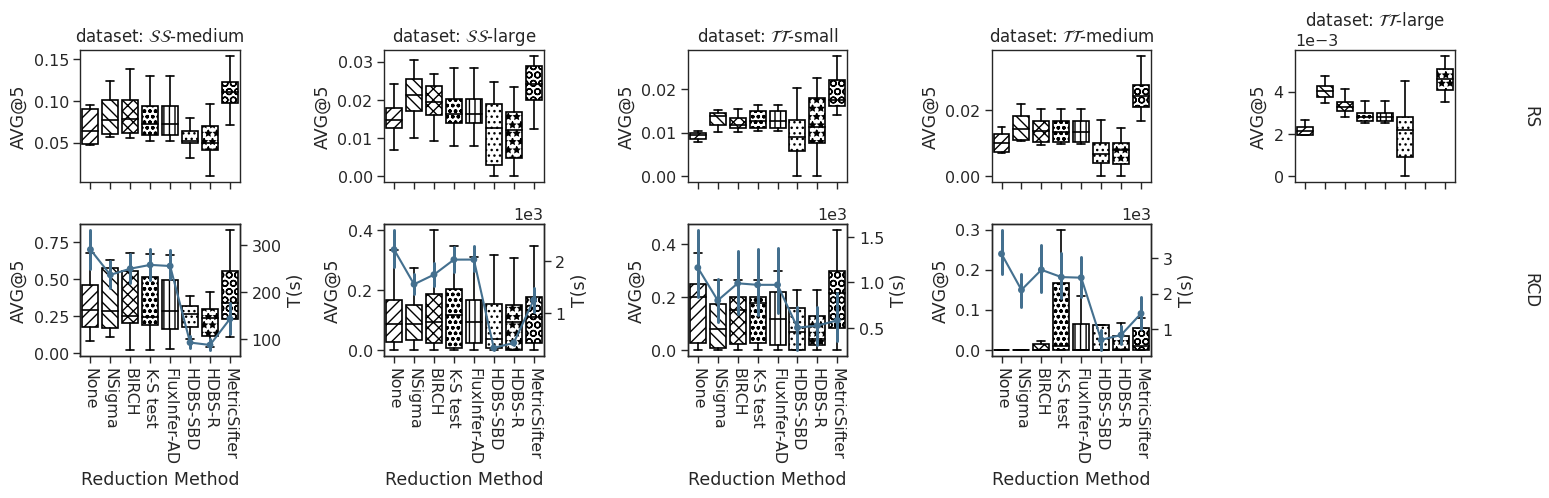

In [76]:
# remove localization methods that perform less well than RS

plot_grid(joined_df, datasets[1:], loc_methods=["RS", "RCD"], col="dataset", row="localization_method")


/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


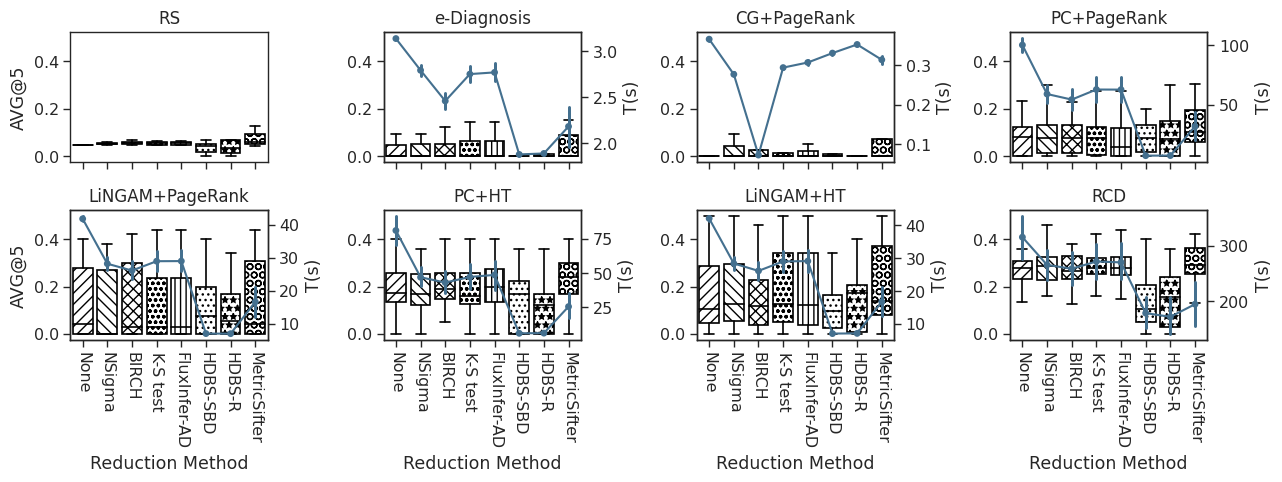

In [74]:
plot_grid_by_dataset(joined_df, "SS-small", "avg@5", "AVG@5", loc_methods=LOC_METHODS)


/tmp/ipykernel_1731813/472637748.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


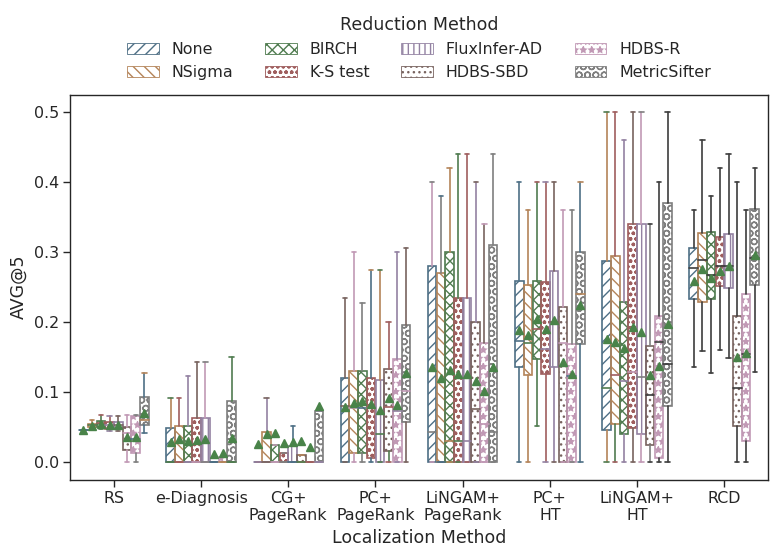

In [77]:
plot_combination(joined_df, "SS-small", "avg@5", "AVG@5", loc_methods=LOC_METHODS)


/tmp/ipykernel_1731813/3913724562.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


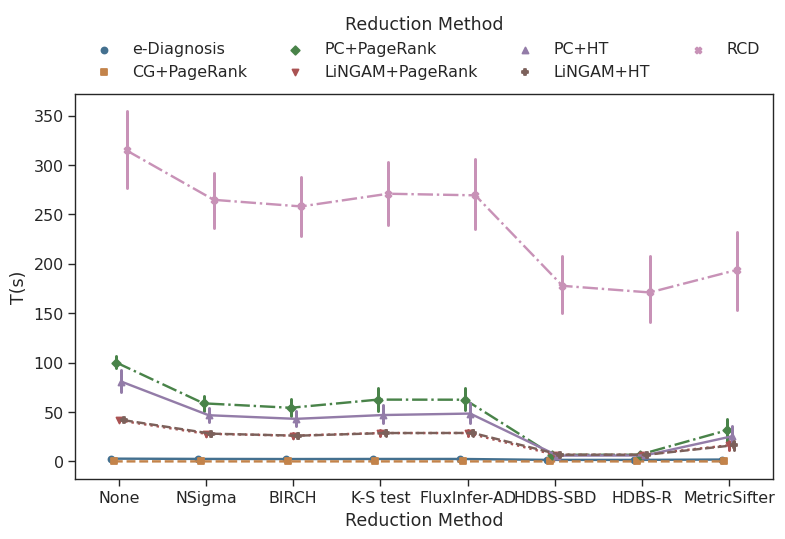

In [52]:
plot_combination(joined_df, "SS-small", "elapsed_time_loc", "T(s)", loc_methods=LOC_METHODS[1:], plot_type="point")


In [53]:
# num_metrics = pd.Series([100, 90, 80])
# num_found_metrics = pd.Series([2, 3, 1])

# def get_scores_of_random_selection(num_metrics: pd.Series, num_found_metrics: pd.Series, max_k: int = 5):

#     def ac_k(num_metrics, num_found_ground_truth, k: int):
#         n, g = num_metrics, num_found_ground_truth
#         prob_single_correct = g / n
#         prob_at_least_one_correct = 1 - (1 - prob_single_correct) ** k
#         return prob_at_least_one_correct.mean()

#     def avg_k(ac_k_) -> dict:
#         return {k: sum([ac_k_[j] for j in range(1, k + 1)]) / k for k in range(1, max_k + 1)}

#     ac_k_ = {k: ac_k(num_metrics, num_found_metrics, k) for k in range(1, max_k + 1)}
#     avg_k_ = avg_k(ac_k_)

#     return {f"AC_{k}": v for k, v in ac_k_.items()}, {f"AVG_{k}": v for k, v in avg_k_.items()}

# get_scores_of_random_selection(num_metrics, num_found_metrics)


## Ablation Study

In [54]:
# TSDR_ABLATION_START_ID, TSDR_ABLATION_END_ID = 894, 899
# TSDR_ABLATION_RUN_IDS = [f"TSDR-{id}" for id in range(TSDR_ABLATION_START_ID, TSDR_ABLATION_END_ID + 1)]
TSDR_ABLATION_RUN_IDS = [f"TSDR-{id}" for id in {1849,1850,1767,1868,1877,1818}]


In [55]:
def convert_to_step_name(phase: str) -> str:
    match phase:
        case "phase1":
            return "STEP0"
        case "phase2":
            return "STEP0-1"
        case "phase3":
            return "STEP0-3"
        case _:
            assert False, f"Unknown phase: {phase}"

def fetch_tsdr_metadata_by_phase(run_id: str) -> list[dict[str, str|float]]:
    with neptune.init_run(
        project="yuuk1/tsdr",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"] == True:
            return []
        dataset = run["dataset"].fetch()
        target_app = dataset["target_app"]
        middleware = dataset["metric_types"]["middlewares"]
        manually_selected = dataset["use_manually_selected_metrics"]

        tsdr_params = run["parameters"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
            multi_dist_type = multi_dist_type

        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (True, True, "changepoint", "changepoint-kde", _):
                reduction = "MetricSifter"
            case (_, _, _, _, _):
                return []
                # assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        csv_path = f"/tmp/summary_by_phase-csv-{run_id}.csv"
        run["scores/summary_by_phase-csv"].download(destination=csv_path)
        summary_by_phase = pd.read_csv(csv_path)
        items = []
        for _, row in summary_by_phase.iterrows():  # skip phase1 simple filtering
            num_series = tuple([int(s) for s in row["num_series/total"].split("/")])
            num_found_cause_metrics = row["cause_metrics/num_mandatory_found_mean"]

            specificity = row["cause_metrics/specificity_mean"]
            recall = row["cause_metrics/recall_mandatory_mean"]
            bacc = row["cause_metrics/bacc_mean"]
            mcc = row["cause_metrics/mcc_mean"]
            elapsed_time = row["elapsed_time"]

            items.append({
                "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                "method": convert_to_step_name(row["phase"]),
                "phase": row["phase"],
                "specificity": specificity, "recall": recall, "bacc": bacc, "mcc": mcc,
                "elapsed_time": elapsed_time,
                "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
                "rs_ac@2": row["RS_AC_2"], "rs_ac@5": row["RS_AC_5"], "rs_avg@5": row["RS_AVG_5"],
            })
        return items


In [56]:
tsdr_phase_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_tsdr_metadata_by_phase)(run) for run in TSDR_ABLATION_RUN_IDS)
assert tsdr_phase_items is not None
tsdr_phase_items = sum(tsdr_phase_items, [])
tsdr_phase_items = [item for item in tsdr_phase_items if item]


https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1877
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1767
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1850
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1849
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1868
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1818
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1767/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1877/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1868/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1849/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune

In [57]:
steps = ["STEP0", "STEP0-1", "STEP0-3"]
metrics = ["specificity", "recall", "bacc", "elapsed_time"]
ss_datasets = ["SS-small", "SS-medium", "SS-large"]
tt_datasets = ["TT-small", "TT-medium", "TT-large"]
datasets = ss_datasets + tt_datasets

multi_level_indexes = pd.MultiIndex.from_product(
    [datasets, steps], names=['Dataset', 'Step'],
)
multi_level_cols = pd.MultiIndex.from_product(
    [datasets, metrics], names=['', ''],
)

tsdr_phase_df = pd.DataFrame(tsdr_phase_items).set_index(['dataset', 'method']).reindex(
    index=multi_level_indexes,
)
tsdr_phase_df["elapsed_time_sum"] = tsdr_phase_df.groupby(level=[0])["elapsed_time"].cumsum()


In [58]:
tsdr_phase_df


phase  specificity    recall      bacc        mcc  \
Dataset   Step                                                          
SS-small  STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.120935  1.000000  0.560467  -0.583098   
          STEP0-3  phase3     0.346632  0.975000  0.660816   0.088060   
SS-medium STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.130083  1.000000  0.565041   0.052579   
          STEP0-3  phase3     0.457775  0.979167  0.718471   0.136381   
SS-large  STEP0    phase1     0.000000  1.000000  0.500000        NaN   
          STEP0-1  phase2     0.088772  0.998437  0.543605   0.020770   
          STEP0-3  phase3     0.493700  0.941810  0.717755   0.059565   
TT-small  STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.297582  0.928571  0.613077   0.028059   
          STEP0-3  phase3     0.548195  0.904762  0.726478   0.050718   
TT-medium STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.251748  0.952381  0.602065   0.028104   
          STEP0-3  phase3     0.655096  0.948413  0.801754   0.073770   
TT-large  STEP0    phase1     0.000000  1.000000  0.500000 -10.000000   
          STEP0-1  phase2     0.168255  0.976190  0.572223   0.010502   
          STEP0-3  phase3     0.650948  0.849773  0.750361   0.028442   

                   elapsed_time  num_metrics(reduced)  num_metrics(filtered)  \
Dataset   Step                                                                 
SS-small  STEP0        0.365774                    64                     64   
          STEP0-1      1.337830                    56                     64   
          STEP0-3      0.309271                    42                     64   
SS-medium STEP0        0.376814                   185                    185   
          STEP0-1      3.006089                   162                    185   
          STEP0-3      0.403848                   102                    185   
SS-large  STEP0        0.485167                  1347                   1347   
          STEP0-1     16.659445                  1229                   1347   
          STEP0-3      1.310194                   687                   1347   
TT-small  STEP0        0.571000                   329                    329   
          STEP0-1      4.984876                   233                    329   
          STEP0-3      0.778895                   149                    329   
TT-medium STEP0        0.784019                  1250                   1250   
          STEP0-1     16.657667                   937                   1250   
          STEP0-3      1.885619                   435                   1250   
TT-large  STEP0        1.661038                  9343                   9343   
          STEP0-1     99.464219                  7779                   9343   
          STEP0-3     13.580952                  3277                   9343   

                   num_metrics(raw)  num_found_cause_metrics   rs_ac@2  \
Dataset   Step                                                           
SS-small  STEP0                  80                 1.000000  0.030802   
          STEP0-1                80                 1.000000  0.035587   
          STEP0-3                80                 0.975000  0.051296   
SS-medium STEP0                 499                 4.437500  0.047151   
          STEP0-1               499                 4.437500  0.054288   
          STEP0-3               499                 4.337500  0.088676   
SS-large  STEP0                6793                 6.800000  0.010018   
          STEP0-1              6793                 6.787500  0.010952   
          STEP0-3              6793                 6.312500  0.018531   
TT-small  STEP0                 408                 1.000000  0.006176   
          STEP0-1               408                 0.928571  0.008070

In [59]:
import itertools

df_display = tsdr_phase_df[["specificity", "recall", "bacc", "elapsed_time_sum"]]
tsdr_s = df_display.style
tsdr_s.clear()
# tsdr_s.highlight_max(subset=(itertools.product(datasets, steps), ["FRR", "RFR", "RFP"]), props='textbf:--rwrap;')\
#     .highlight_min(subset=(itertools.product(datasets, steps), ["elapsed_time"]), props='textbf:--rwrap;')
tsdr_s.format({"RFP": '{:.4f}'}, precision=3)
tsdr_s.set_table_styles([
    {'selector': 'toprule', 'props': ':toprule;'},
    {'selector': 'bottomrule', 'props': ':bottomrule;'},
], overwrite=False)

def highlight_max(s, props='textbf:--rwrap;'):
    is_max = s == s.max()
    return [props if v else '' for v in is_max]

def highlight_min(s, props='textbf:--rwrap;'):
    is_min = s == s.min()
    return [props if v else '' for v in is_min]

for dataset in datasets:
    tsdr_s.apply(highlight_max, subset=(itertools.product([dataset], steps), ["specificity", "recall", "bacc"]), axis=0)
    # tsdr_s.apply(highlight_min, subset=(itertools.product([dataset], steps), ["elapsed_time"]), axis=0)
print(tsdr_s.to_latex(hrules=True))


\begin{tabular}{llrrrr}
\toprule
 &  & specificity & recall & bacc & elapsed_time_sum \\
Dataset & Step &  &  &  &  \\
\midrule
\multirow[c]{3}{*}{SS-small} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 0.366 \\
 & STEP0-1 & 0.121 & \textbf{1.000} & 0.560 & 1.704 \\
 & STEP0-3 & \textbf{0.347} & 0.975 & \textbf{0.661} & 2.013 \\
\multirow[c]{3}{*}{SS-medium} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 0.377 \\
 & STEP0-1 & 0.130 & \textbf{1.000} & 0.565 & 3.383 \\
 & STEP0-3 & \textbf{0.458} & 0.979 & \textbf{0.718} & 3.787 \\
\multirow[c]{3}{*}{SS-large} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 0.485 \\
 & STEP0-1 & 0.089 & 0.998 & 0.544 & 17.145 \\
 & STEP0-3 & \textbf{0.494} & 0.942 & \textbf{0.718} & 18.455 \\
\multirow[c]{3}{*}{TT-small} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 0.571 \\
 & STEP0-1 & 0.298 & 0.929 & 0.613 & 5.556 \\
 & STEP0-3 & \textbf{0.548} & 0.905 & \textbf{0.726} & 6.335 \\
\multirow[c]{3}{*}{TT-medium} & STEP0 & 0.000 & \textbf{1.000} & 0.500 & 0.784 \\
 & ST